In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.0 MB/s eta 0:00:00


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
import shap
#from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [3]:
def Get_Data():
  df_xray = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/xray.pkl")
  df_clinical = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/clinical.pkl")
  df_mri = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/mri.pkl")
  df_questionnaires = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/questionnaires.pkl")
  df_tomography = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/tomography.pkl")
  df_biomarkers = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/biomarkers.pkl")
  df_progression = pd.read_csv('/content/drive/MyDrive/Dissertation Final/progression.csv')
  return(df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression)

In [4]:
df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression = Get_Data()

In [5]:
df_xray.shape

(297, 24)

In [6]:
df_mri.shape

(297, 133)

In [7]:
(df_xray.isnull().sum().sum()/df_xray.size)*100

1.3187429854096522

In [8]:
(df_mri.isnull().sum().sum()/df_mri.size)*100

3.6556036556036555

In [9]:
df_progression

ID  S  P
0      1  0  0
1      5  0  0
2      7  1  1
3     11  0  1
4     12  0  1
..   ... .. ..
218  424  0  0
219  426  1  0
220  432  0  1
221  433  0  0
222  434  1  1

[223 rows x 3 columns]

<Axes: xlabel='S', ylabel='count'>

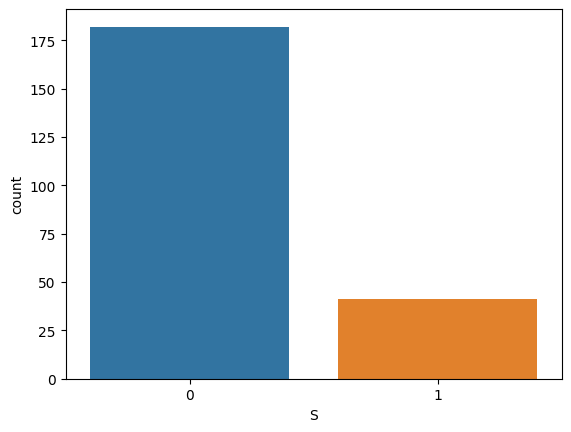

In [10]:
#Switch between 'S' and 'P' to see the class label distribution
sns.countplot(x=df_progression['S'])

In [11]:
df_progression['multiclass_labels'] = df_progression['P'] * 2 + df_progression['S']

In [12]:
df_progression

ID  S  P  multiclass_labels
0      1  0  0                  0
1      5  0  0                  0
2      7  1  1                  3
3     11  0  1                  2
4     12  0  1                  2
..   ... .. ..                ...
218  424  0  0                  0
219  426  1  0                  1
220  432  0  1                  2
221  433  0  0                  0
222  434  1  1                  3

[223 rows x 4 columns]

In [13]:
df_progression = df_progression.drop(['S','P'],axis =1)

In [14]:
df_progression, df_progression.shape


(      ID  multiclass_labels
 0      1                  0
 1      5                  0
 2      7                  3
 3     11                  2
 4     12                  2
 ..   ...                ...
 218  424                  0
 219  426                  1
 220  432                  2
 221  433                  0
 222  434                  3
 
 [223 rows x 2 columns],
 (223, 2))

In [15]:
df_progression['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

In [16]:
def Join_DataSets(df1,df2):
  return(df1.join(df2))

In [17]:
joined_df = Join_DataSets(df_tomography, df_questionnaires)

In [18]:
joined_df.shape

(297, 353)

In [19]:
id_sub = df_xray.index
output = {n: int(str(n)[-3:]) for n in id_sub}

In [20]:
dic_reversed = {v: k for k, v in output.items()}
df_progression['Key'] = df_progression['ID'].map(dic_reversed)
df_progression['Key'] = df_progression['Key'].replace({np.nan: 'NaN'})

In [21]:
df_progression = df_progression.drop(['ID'],axis =1)

In [22]:
merged_df = pd.merge(df_progression, joined_df , left_on='Key', right_on='Subject ID')

In [23]:
merged_df = merged_df.drop(['Key'],axis =1)

#**Exploratory Data Analysis**

In [24]:
merged_df.shape

(223, 354)

In [25]:
merged_df['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

<Axes: xlabel='multiclass_labels', ylabel='count'>

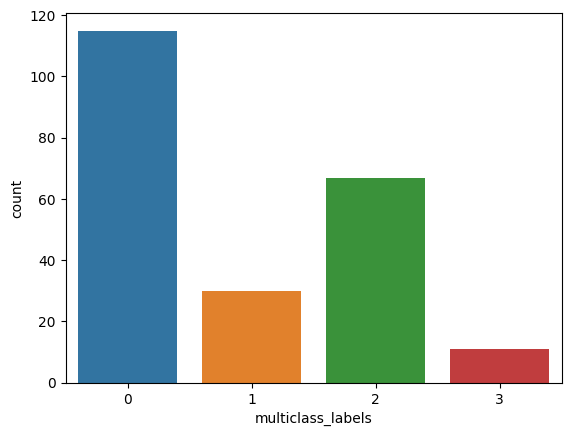

In [26]:
sns.countplot(x=merged_df['multiclass_labels'])

In [27]:
merged_df.isnull().sum()

multiclass_labels          0
Cyst_K                     0
JSN_K                      0
OA_K                       0
Osteophyte_K               0
                          ..
HOOS_sport                 5
HOOS_QOL                   3
Hands_Max_NRS_Last_Week    5
Hip_Max_NRS_Last_Week      6
Knees_Max_NRS_Last_Week    2
Length: 354, dtype: int64

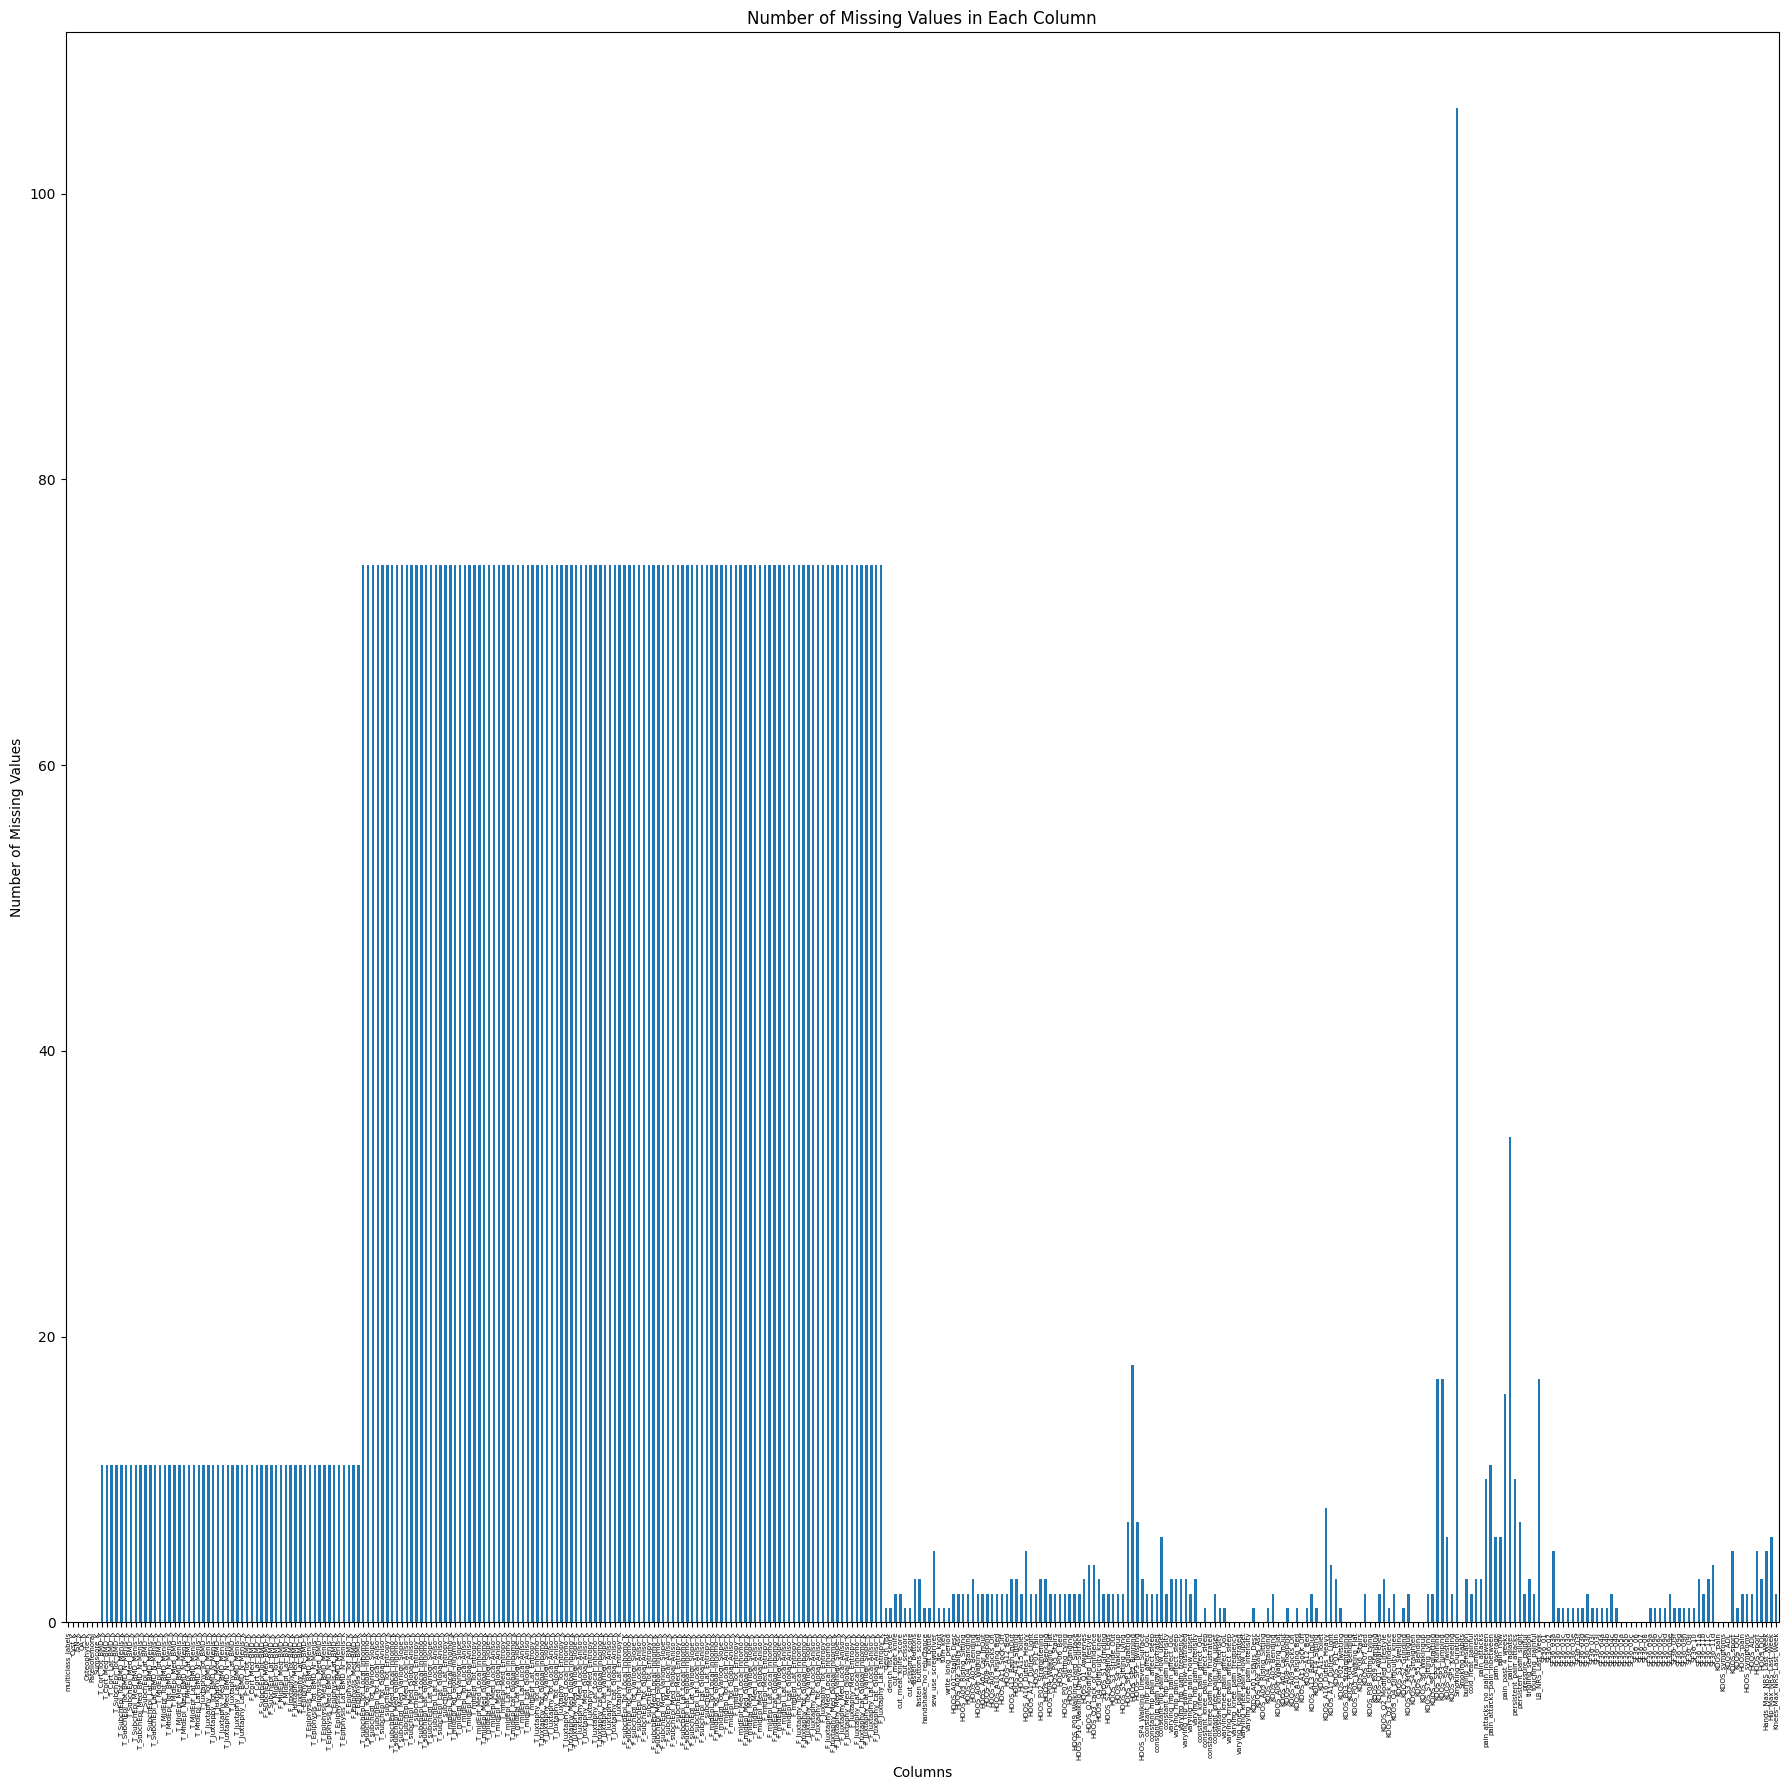

In [28]:
plt.figure(figsize=(18, 18))
merged_df.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

In [29]:
numerical_count = merged_df.select_dtypes(include=['int', 'float']).shape[1]
categorical_count = merged_df.select_dtypes(include=['object', 'category']).shape[1]

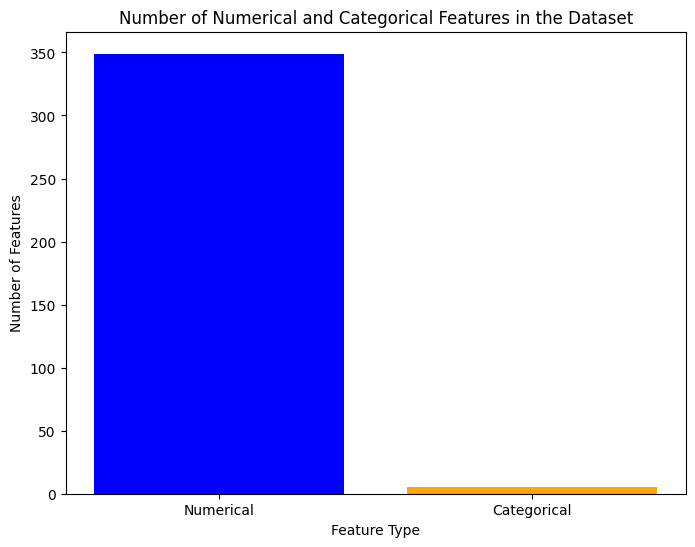

In [30]:
plt.figure(figsize=(8, 6))
plt.bar(['Numerical', 'Categorical'], [numerical_count, categorical_count], color=['blue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Number of Features')
plt.title('Number of Numerical and Categorical Features in the Dataset')
plt.show()

<Axes: >

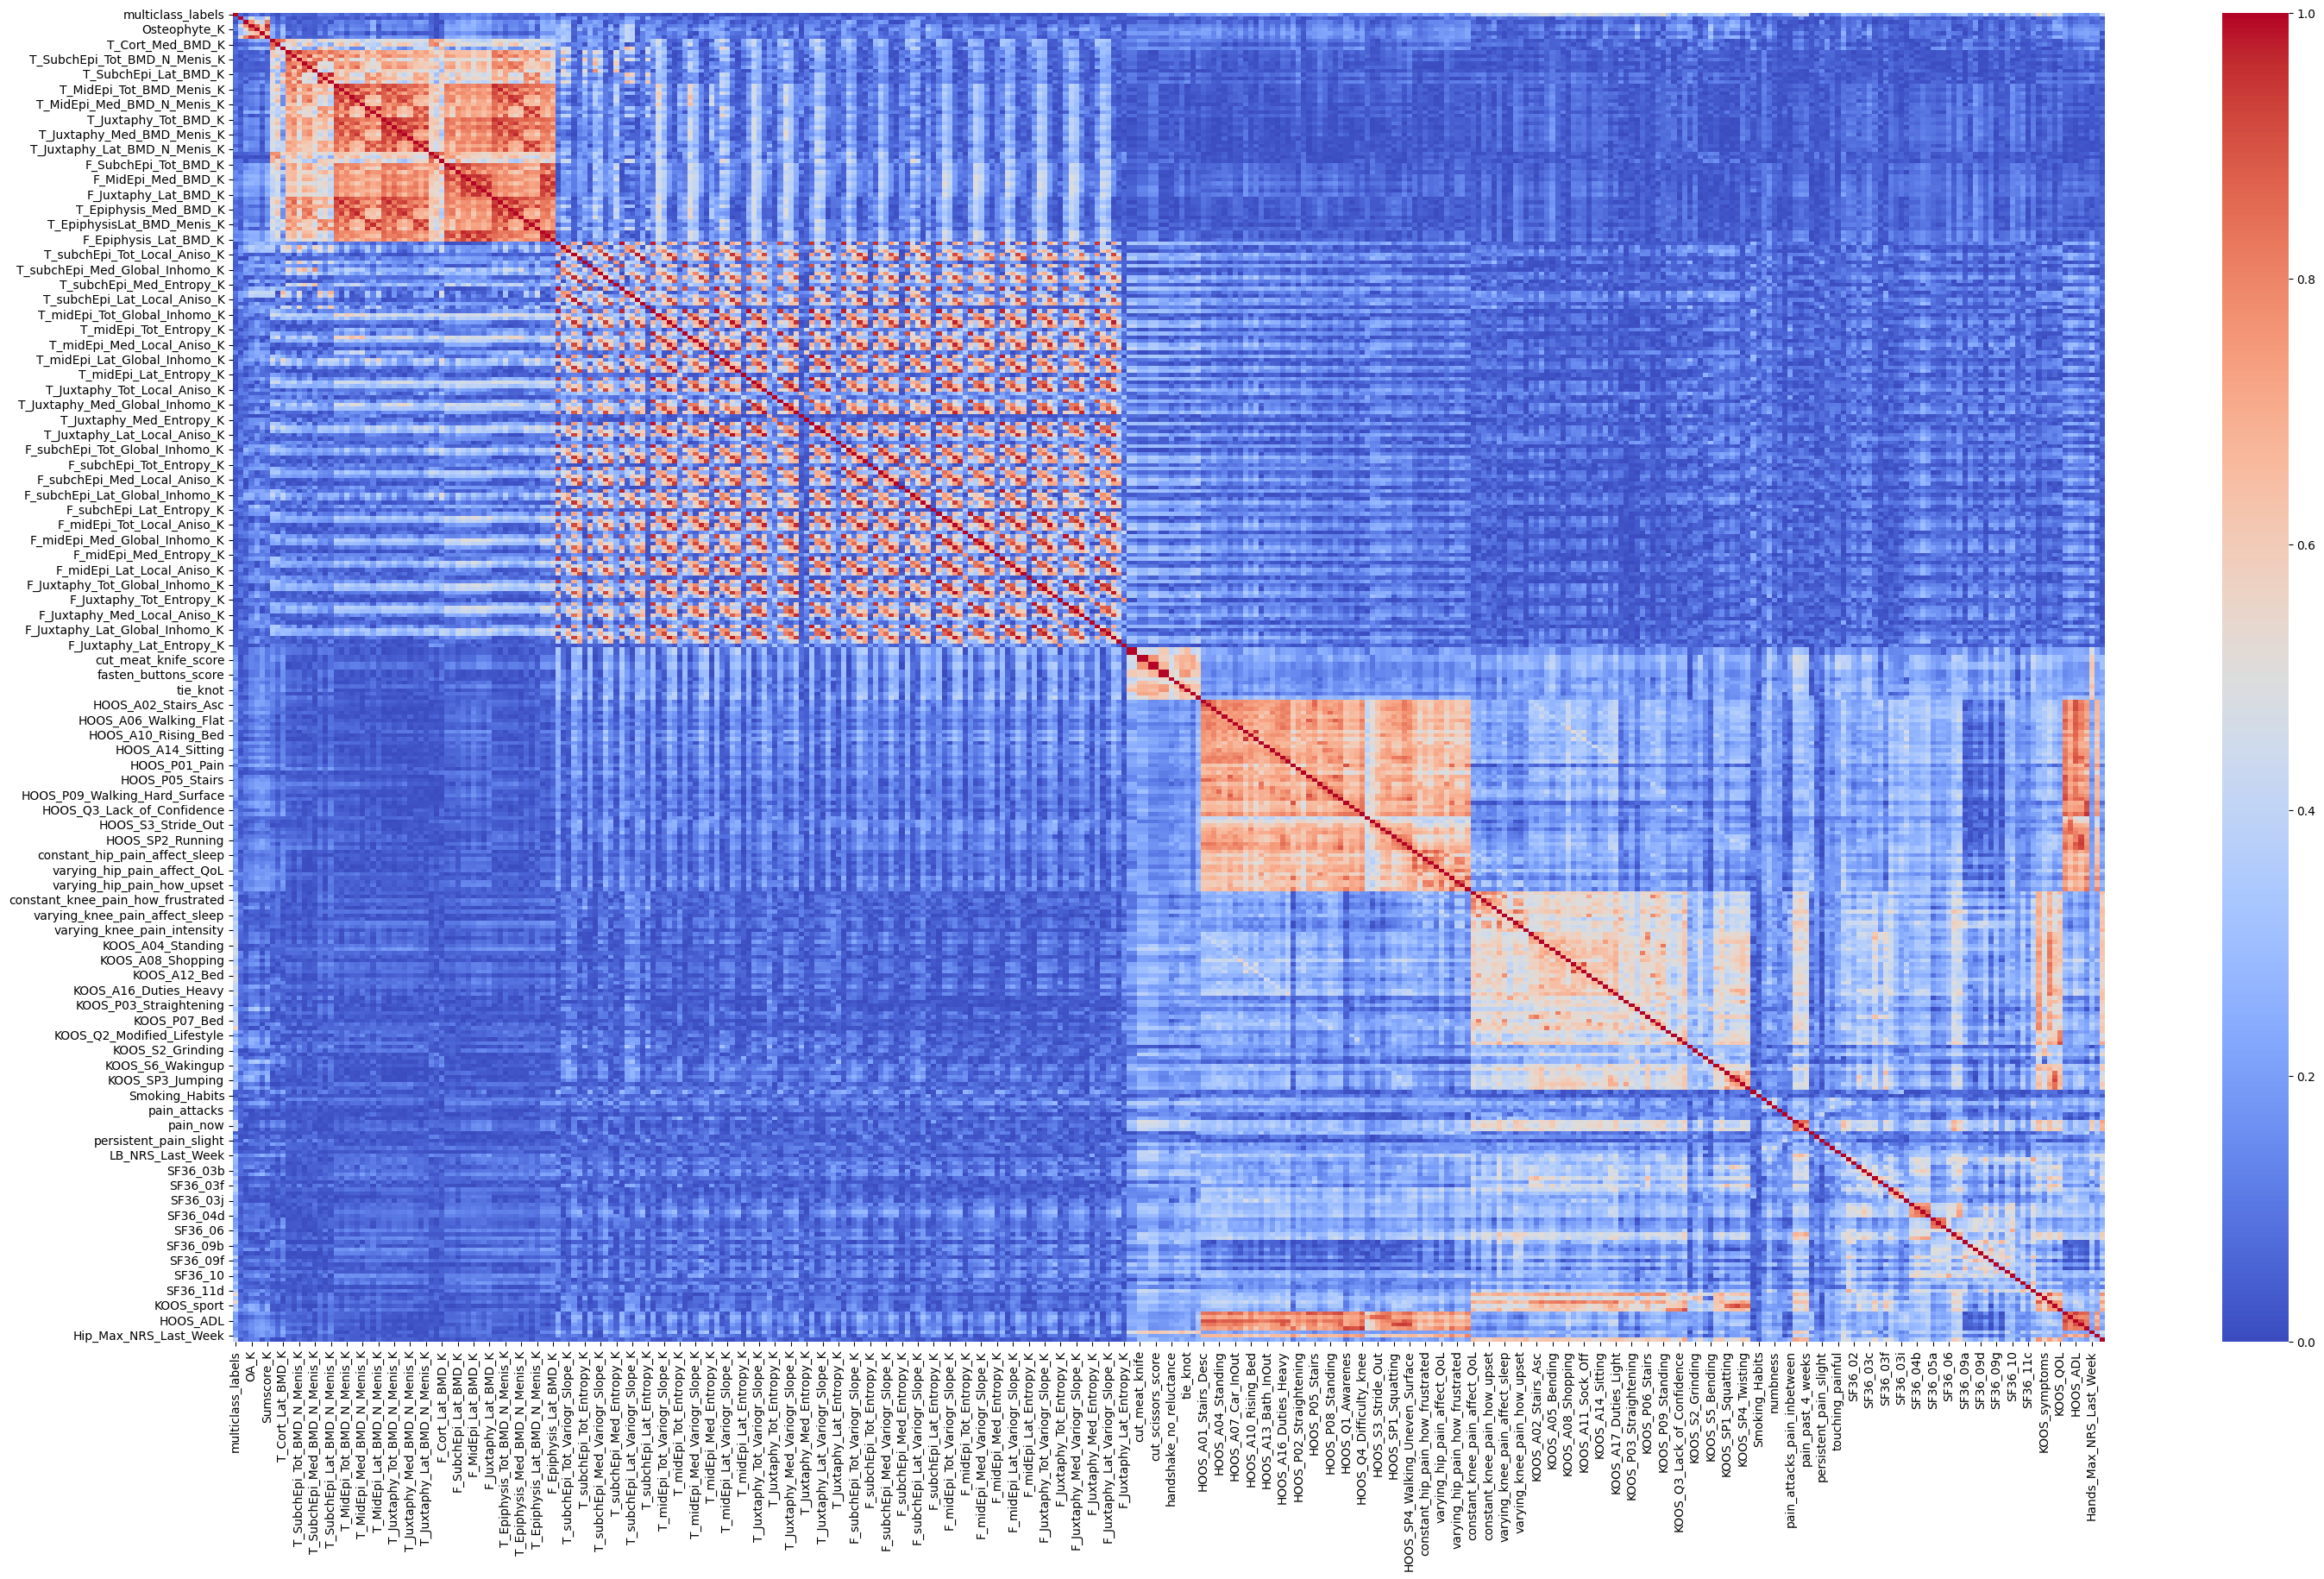

In [31]:
correlation_heatmap = merged_df.astype(float).corr().abs()
plt.figure(figsize = (35,20))
sns.heatmap(correlation_heatmap,annot=False,cmap = 'coolwarm')

In [32]:
summary_stats = merged_df.describe()
summary_stats

multiclass_labels    Cyst_K     JSN_K      OA_K  Osteophyte_K  \
count         223.000000     223.0     223.0     223.0         223.0   
mean            0.883408   0.29148  1.641256  1.569507      1.650224   
std             1.002179  0.455466  0.792136  0.936431      1.028244   
min             0.000000       0.0       0.0       0.0           0.0   
25%             0.000000       0.0       1.0       1.0           1.0   
50%             0.000000       0.0       2.0       2.0           2.0   
75%             2.000000       1.0       2.0       2.0           3.0   
max             3.000000       1.0       3.0       3.0           3.0   

       Patellofemoral  Sumscore_K  T_Cort_Tot_BMD_K  T_Cort_Med_BMD_K  \
count           223.0       223.0        212.000000        212.000000   
mean         1.600897     3.58296        428.949481        442.264953   
std          1.085282    1.791138         55.111933         65.696795   
min               0.0         0.0        303.880000        276.930000   
25%               1.0         2.0        394.655000        402.240000   
50%               1.0         4.0        425.970000        440.915000   
75%               3.0         5.0        460.777500        478.932500   
max               3.0         7.0        665.810000        702.580000   

       T_Cort_Lat_BMD_K  ...  KOOS_sport    KOOS_QOL   HOOS_pain  \
count        212.000000  ...  218.000000  222.000000  221.000000   
mean         407.352877  ...   42.750382   47.691441   78.727376   
std           62.117900  ...   26.296427   20.680722   20.782274   
min          279.860000  ...    0.000000   -6.250000   -2.500000   
25%          366.407500  ...   25.000000   31.250000   67.500000   
50%          400.895000  ...   40.000000   43.750000   85.000000   
75%          445.362500  ...   60.000000   62.500000   97.500000   
max          644.960000  ...  100.000000   93.750000   97.500000   

       HOOS_symptoms    HOOS_ADL  HOOS_sport    HOOS_QOL  \
count     221.000000  221.000000  218.000000  220.000000   
mean       80.656109   82.285567   74.063456   69.280303   
std        21.157404   20.570654   27.740370   24.723285   
min         0.000000    4.411765    0.000000    0.000000   
25%        65.000000   70.588235   56.250000   50.000000   
50%        90.000000   91.176471   81.250000   75.000000   
75%       100.000000  100.000000  100.000000   93.750000   
max       100.000000  100.000000  100.000000   93.750000   

       Hands_Max_NRS_Last_Week  Hip_Max_NRS_Last_Week  Knees_Max_NRS_Last_Week  
count               218.000000             217.000000               221.000000  
mean                  4.110092               2.930876                 4.701357  
std                   3.139871               2.923376                 2.743827  
min                   0.000000               0.000000                 0.000000  
25%                   1.000000               0.000000                 2.000000  
50%                   4.000000               2.000000                 5.000000  
75%                   7.000000               6.000000                 7.000000  
max                  10.000000              10.000000                10.000000  

[8 rows x 349 columns]

#**Pre-processing**

In [33]:
merged_df.dropna(axis=1, thresh=0.6 * merged_df.shape[0], inplace=True)
merged_df = merged_df.loc[:, merged_df.apply(lambda column: column.nunique() > 1)]

In [34]:
merged_df.shape

(223, 353)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.drop(columns=['multiclass_labels']),merged_df['multiclass_labels'],test_size = 0.2)

In [36]:
X_train_column_names = X_train.columns.tolist()
X_train_numerical_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train_categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()


In [37]:
X_train_categorical_feature_indices = [X_train.columns.get_loc(col) for col in X_train_categorical_features]

In [38]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(7164, 1899)

In [39]:
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer()), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_numerical_features),
        ("cat", categorical_transformer, X_train_categorical_features),
    ]
)

In [40]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [41]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = X_train_column_names )
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = X_train_column_names)

In [42]:
X_train_preprocessed.isnull().sum().sum(), X_test_preprocessed.isnull().sum().sum()

(0, 0)

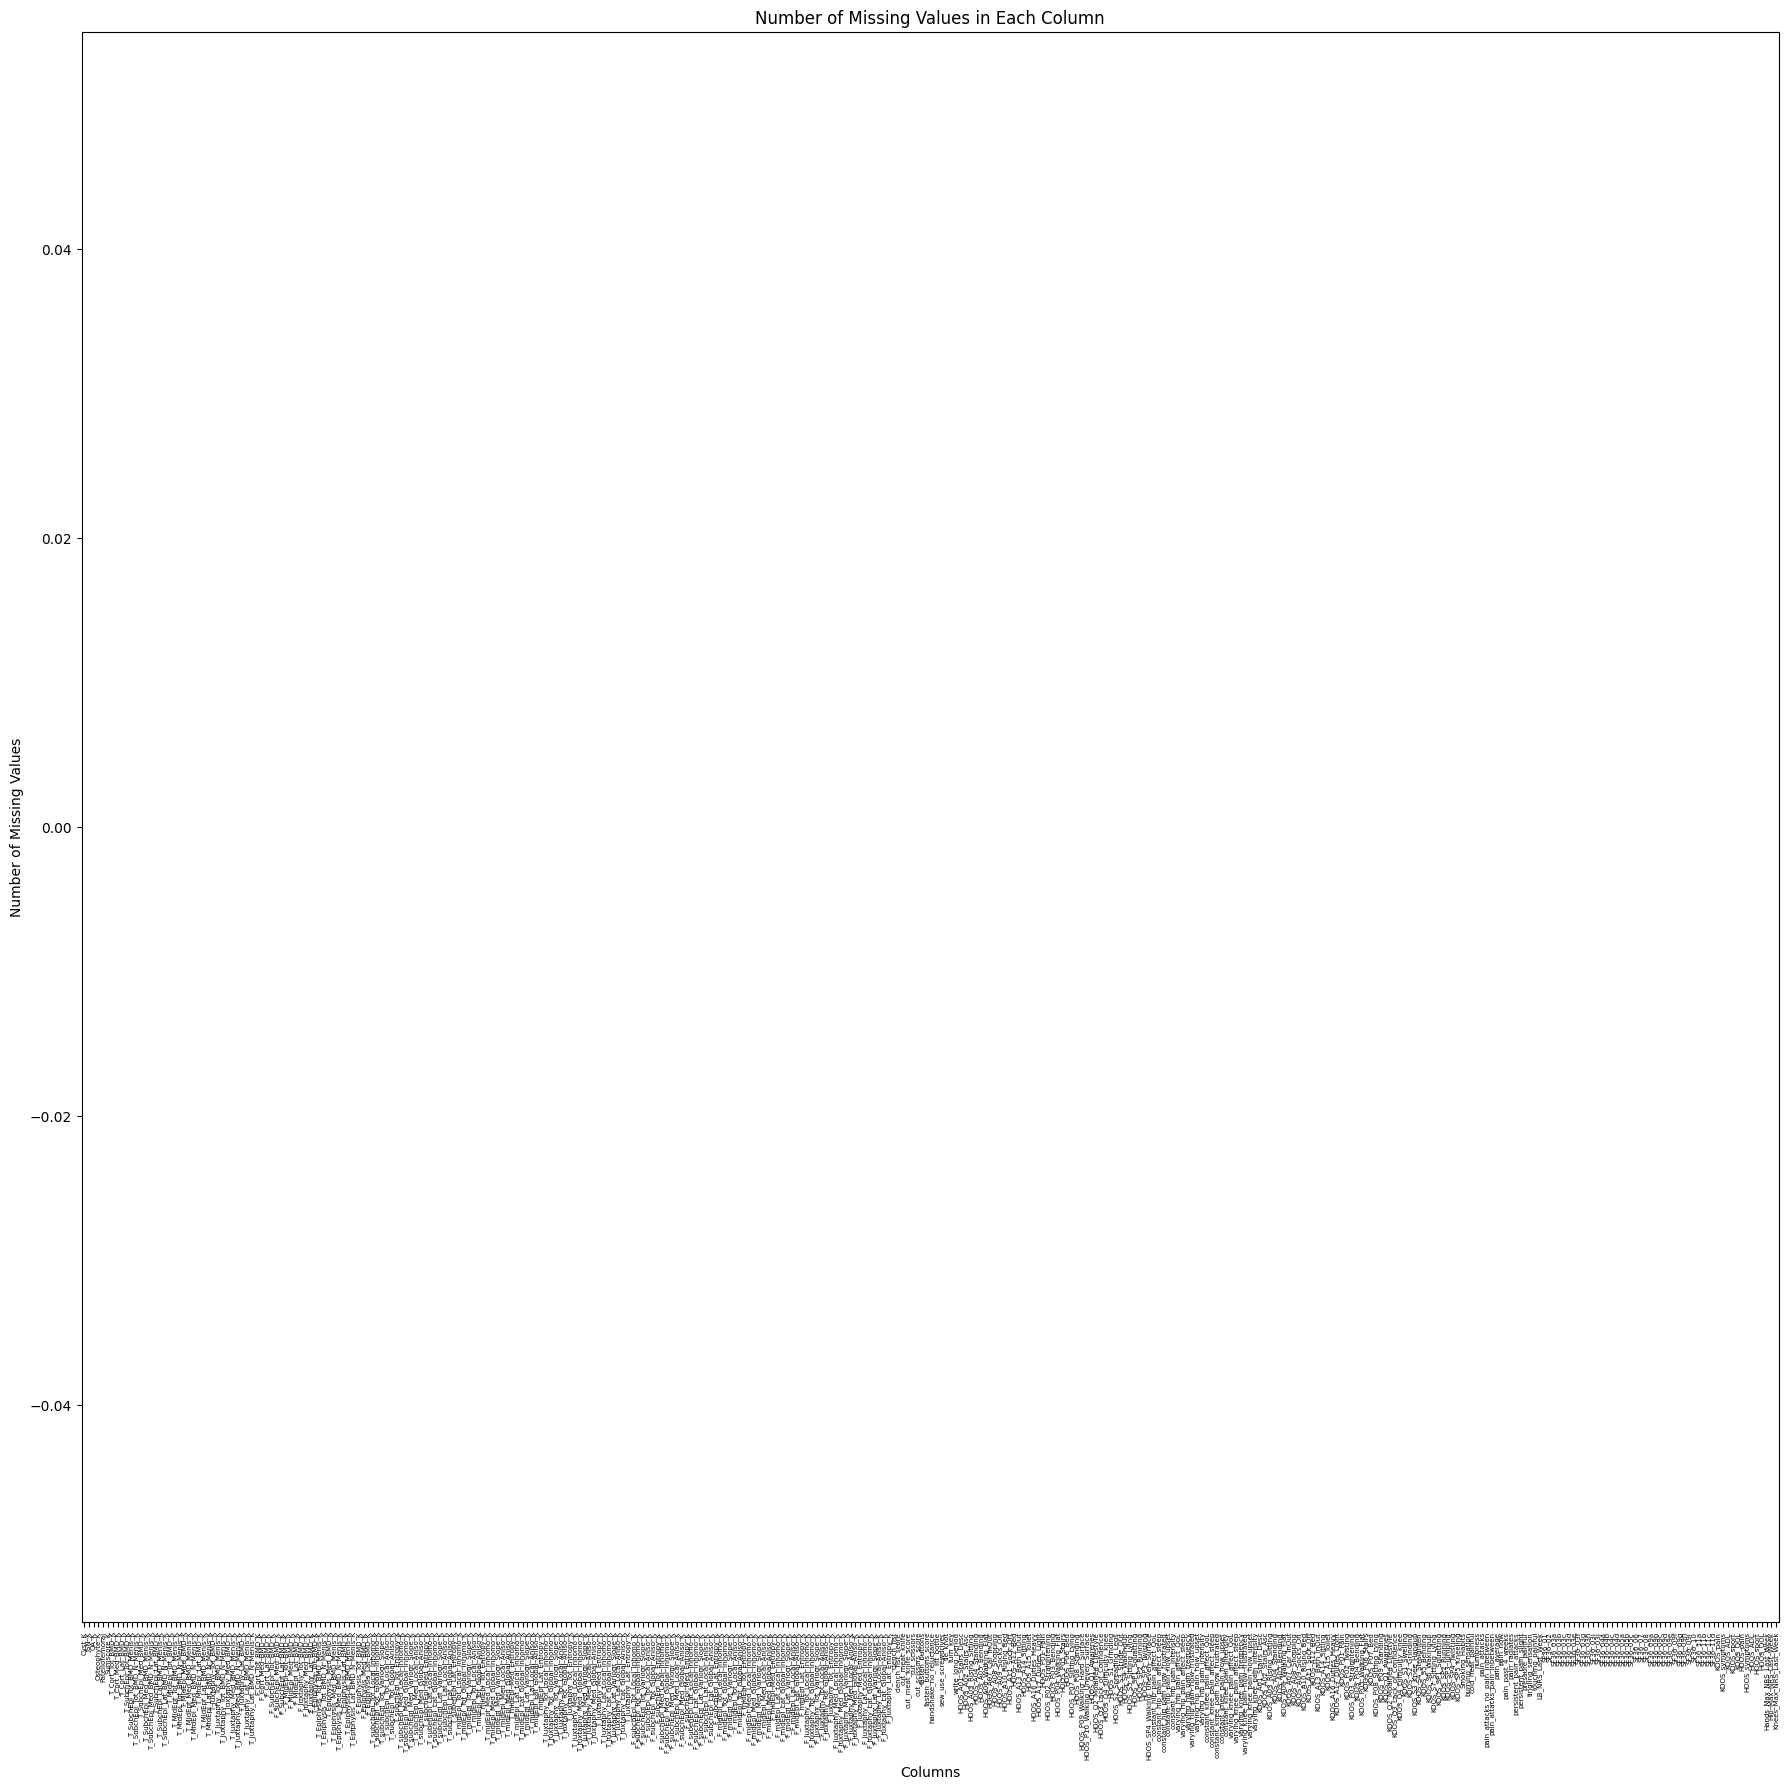

In [43]:
plt.figure(figsize=(18, 18))
X_test_preprocessed.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

#**Oversampling**

In [44]:
y_train.value_counts()

0    90
2    57
1    22
3     9
Name: multiclass_labels, dtype: int64

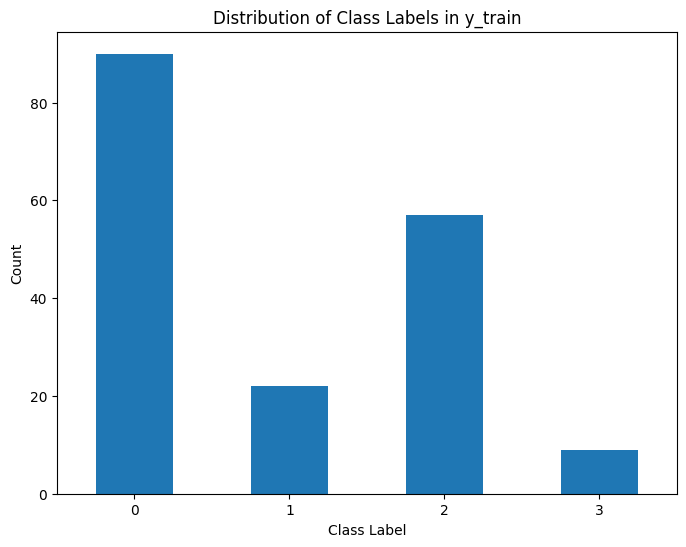

In [45]:
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [46]:
oversample = SMOTENC(categorical_features=X_train_categorical_feature_indices, random_state=42)
X_train_preprocessed_balanced, y_train_balanced = oversample.fit_resample(X_train_preprocessed, y_train)


In [47]:
y_train_balanced.value_counts()

0    90
1    90
2    90
3    90
Name: multiclass_labels, dtype: int64

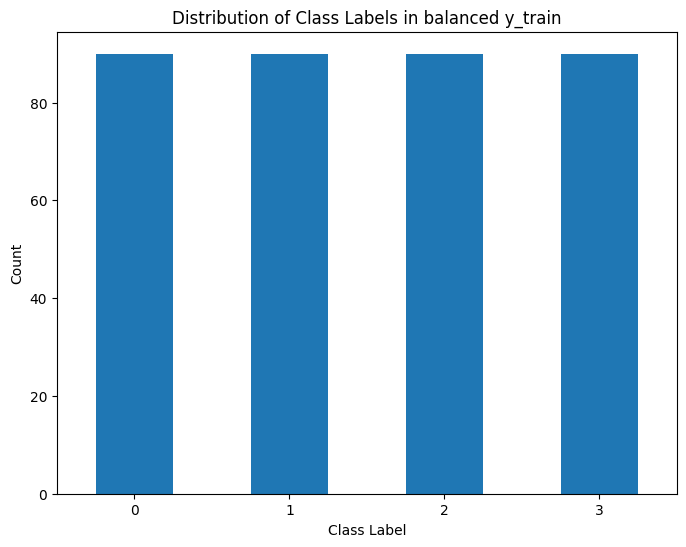

In [48]:
plt.figure(figsize=(8, 6))
y_train_balanced.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in balanced y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#**One hot encoding**

In [49]:
def perform_one_hot_encoding(data1,data2, categorical_columns):
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  encoded_columns1 = encoder.fit_transform(data1[categorical_columns])
  encoded_columns2 = encoder.transform(data2[categorical_columns])
  encoded_data1 = pd.DataFrame(encoded_columns1, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_data2 = pd.DataFrame(encoded_columns2, columns=encoder.get_feature_names_out(categorical_columns))
  print(encoded_data1.shape)
  data1 = data1.drop(columns=categorical_columns)
  data2 = data2.drop(columns=categorical_columns)
  data1 = pd.concat([data1, encoded_data1], axis=1)
  data2 = pd.concat([data2, encoded_data2], axis=1)
  return data1,data2

In [50]:
X_train_preprocessed_balanced_encoded, X_test_preprocessed_encoded = perform_one_hot_encoding(X_train_preprocessed_balanced,X_test_preprocessed, X_train_categorical_features)


(360, 57)


In [51]:
X_train_preprocessed_balanced_encoded.shape, X_test_preprocessed_encoded.shape

((360, 404), (45, 404))

# **Feature selection using correlation**

In [52]:
def highly_correlated(df):
  correlations = df.astype(float).corr().abs()
  mask = np.triu(np.ones(correlations.shape), k=1).astype(bool)
  correlations.where(mask, inplace=True)
  print("Correlation Matrix:")
  print(correlations)
  columns_to_drop = [i for i in correlations if any(abs(correlations[i]) >= 0.7)]
  df.drop(columns=columns_to_drop, inplace=True)
  plt.figure(figsize = (35,20))
  sns.heatmap(correlations,annot=False,cmap = 'coolwarm')
  return(df)

Correlation Matrix:
                             Cyst_K     JSN_K      OA_K  Osteophyte_K  \
Cyst_K                          NaN  0.245728  0.460299      0.234819   
JSN_K                           NaN       NaN  0.791301      0.564783   
OA_K                            NaN       NaN       NaN      0.868173   
Osteophyte_K                    NaN       NaN       NaN           NaN   
Patellofemoral                  NaN       NaN       NaN           NaN   
...                             ...       ...       ...           ...   
persistent_pain_slight_0.0      NaN       NaN       NaN           NaN   
persistent_pain_slight_0.25     NaN       NaN       NaN           NaN   
persistent_pain_slight_0.5      NaN       NaN       NaN           NaN   
persistent_pain_slight_0.75     NaN       NaN       NaN           NaN   
persistent_pain_slight_1.0      NaN       NaN       NaN           NaN   

                             Patellofemoral  Sumscore_K  T_Cort_Tot_BMD_K  \
Cyst_K                    

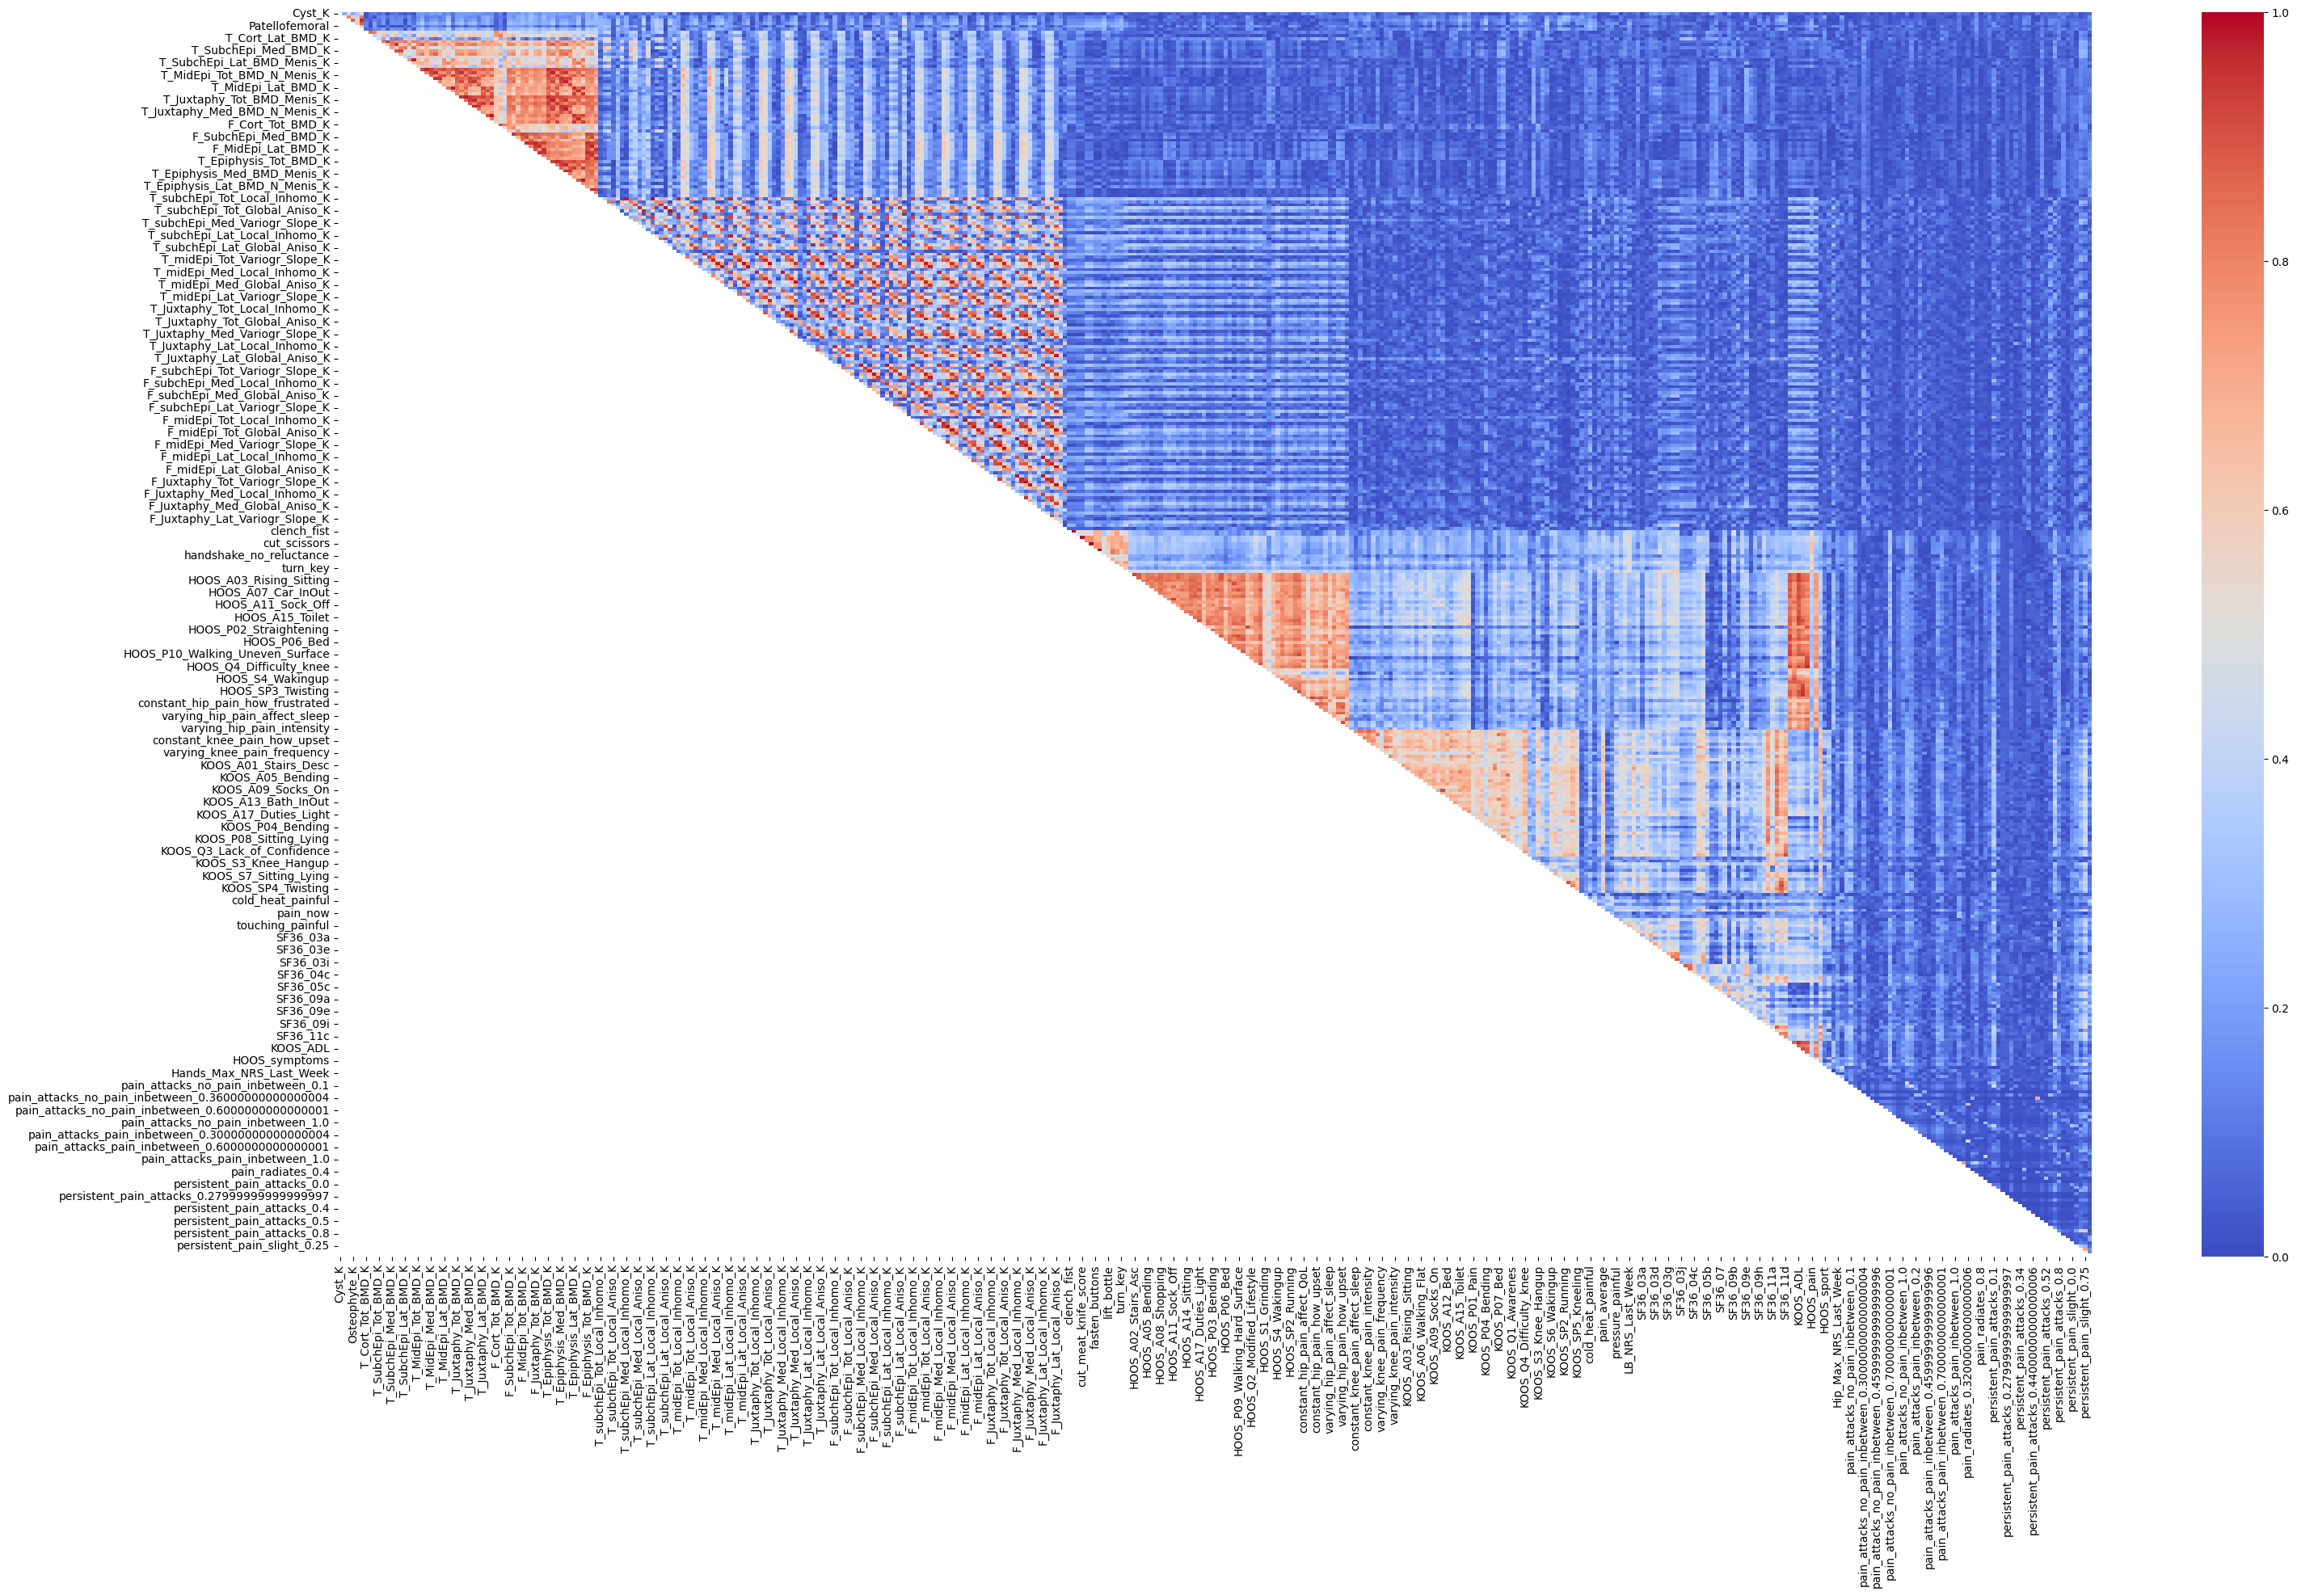

In [53]:
X_train_preprocessed_balanced_encoded_corr = highly_correlated(X_train_preprocessed_balanced_encoded)

<Axes: >

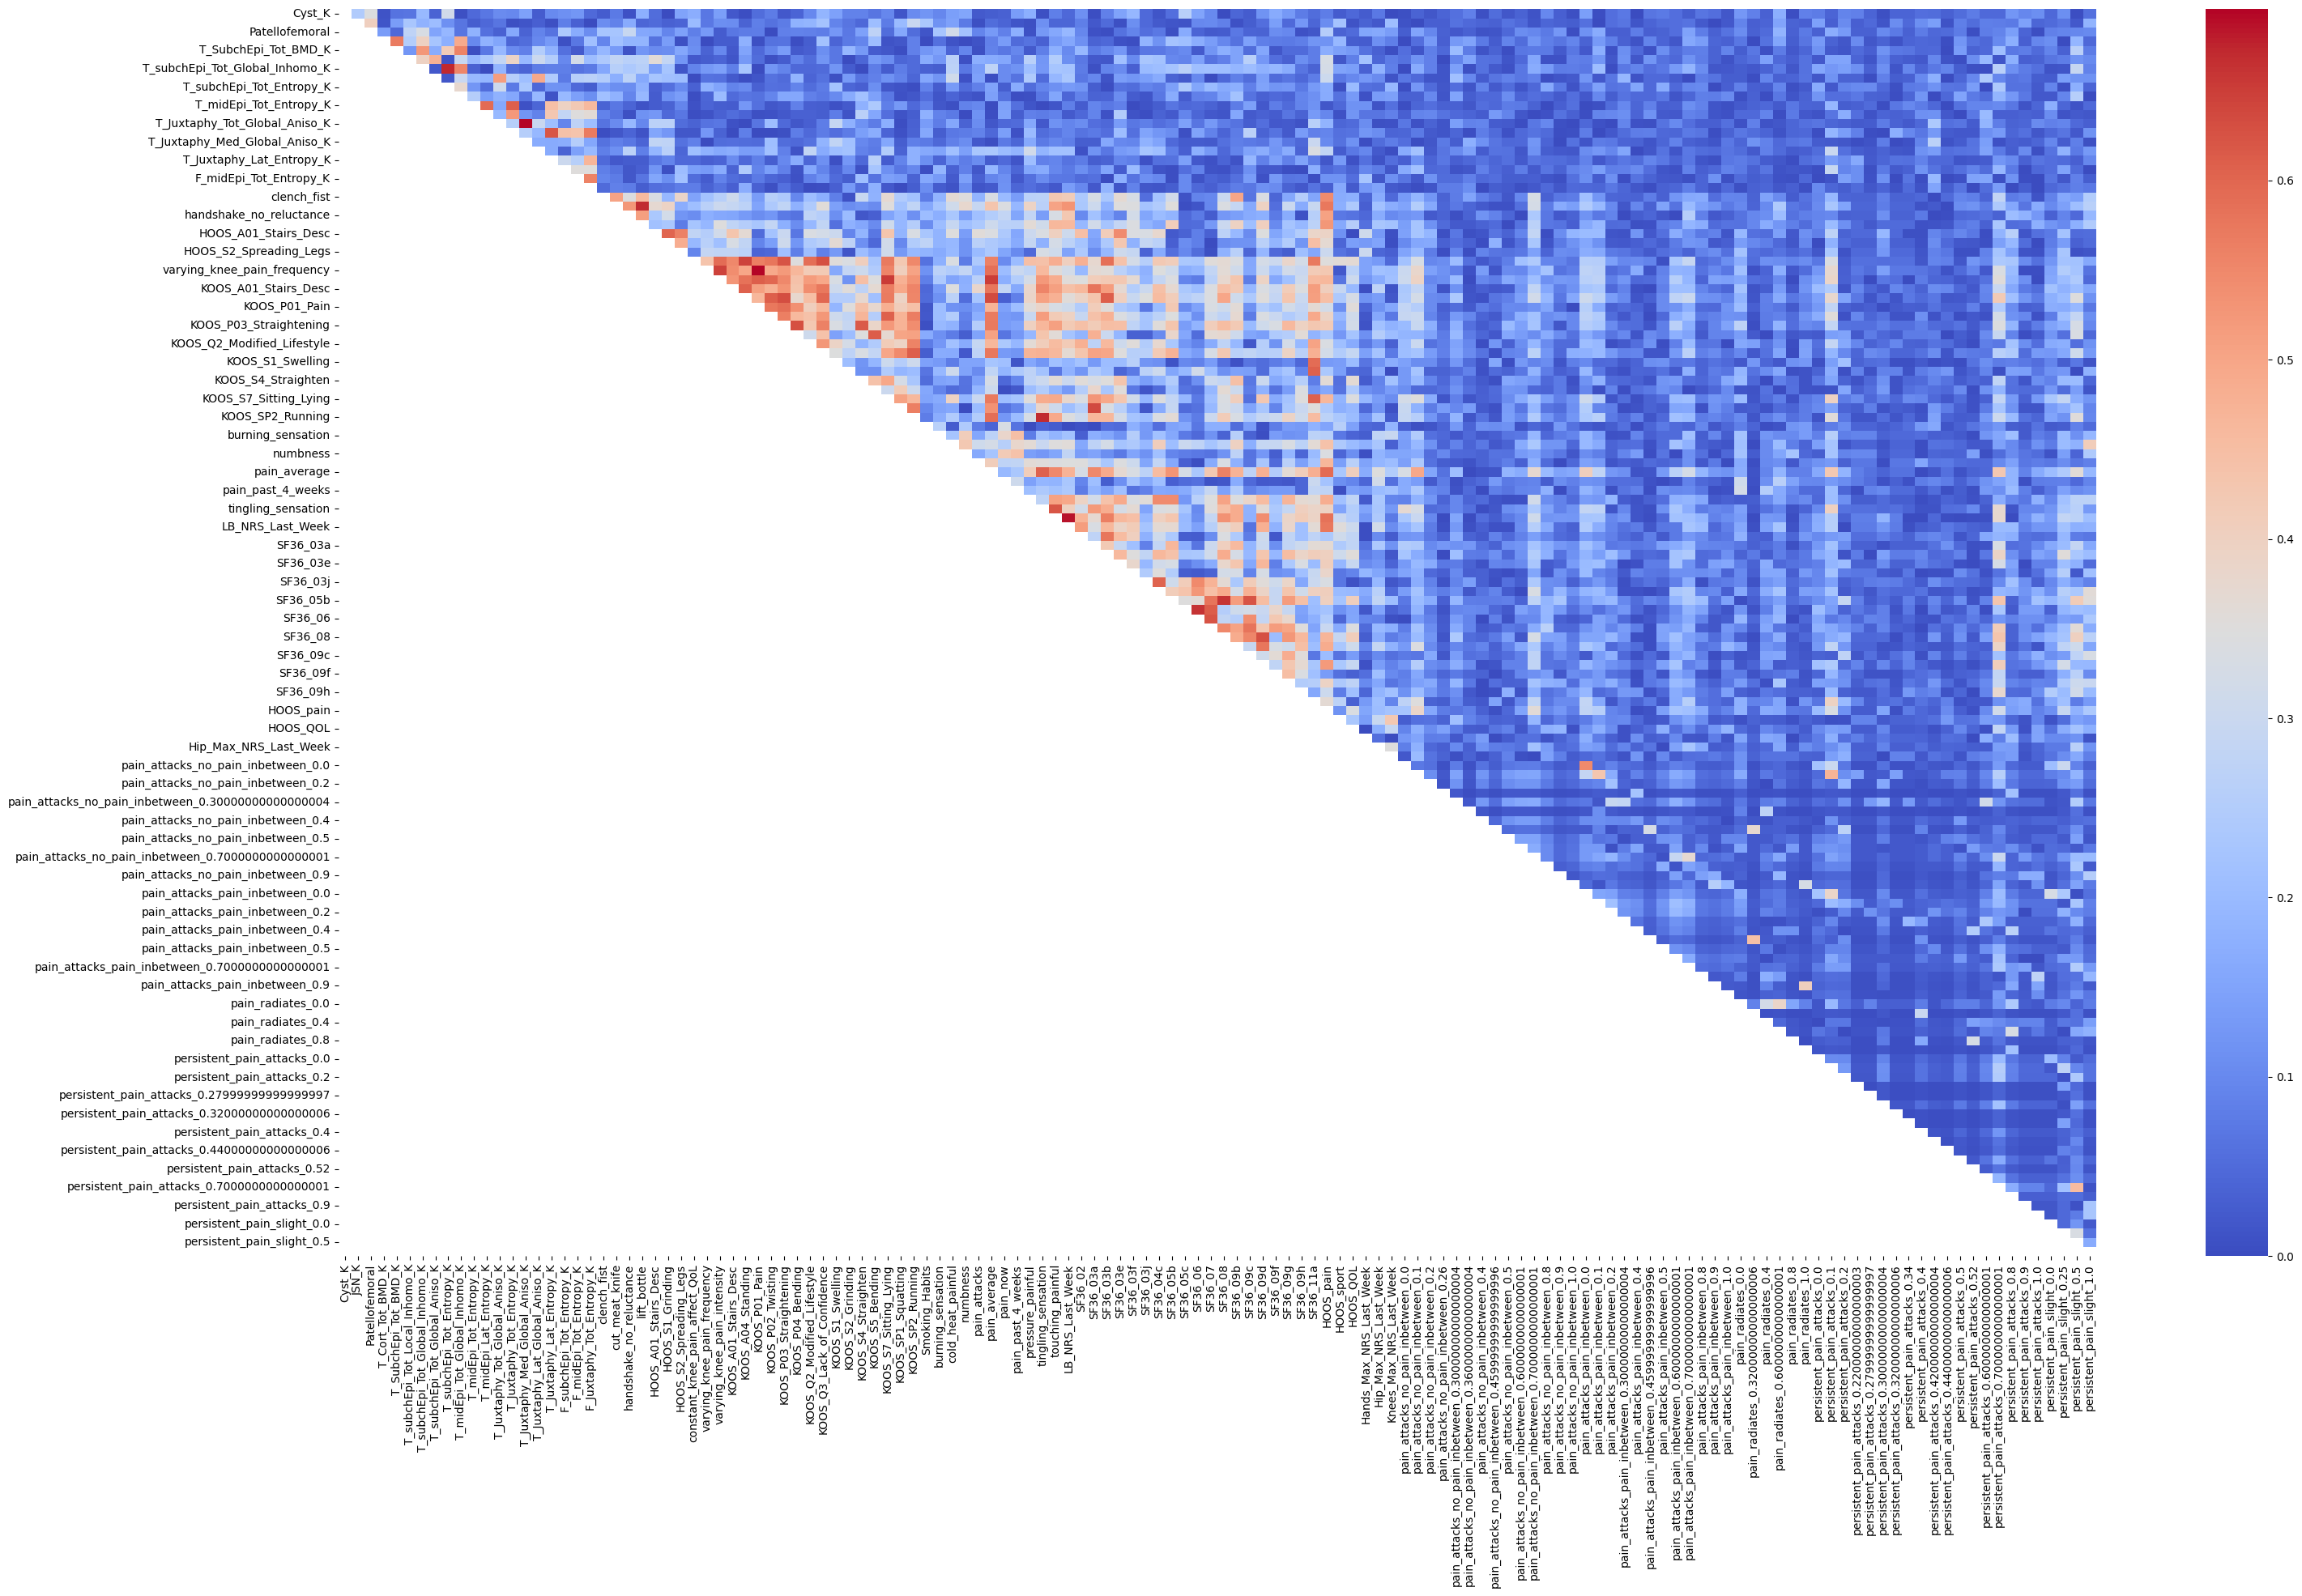

In [54]:
correlation_new = X_train_preprocessed_balanced_encoded_corr.astype(float).corr().abs()
mask = np.triu(np.ones(correlation_new.shape), k=1).astype(bool)
correlation_new.where(mask, inplace=True)
plt.figure(figsize = (35,20))
sns.heatmap(correlation_new,annot=False,cmap = 'coolwarm')

In [55]:
X_train_preprocessed_balanced_encoded_corr.shape

(360, 136)

In [56]:
column_names_final  = X_train_preprocessed_balanced_encoded_corr.columns.tolist()

In [57]:
X_test_preprocessed_encoded_corr = X_test_preprocessed_encoded[column_names_final]

In [58]:
X_train_preprocessed_balanced_encoded_corr.shape,X_test_preprocessed_encoded_corr.shape,y_train_balanced.shape,y_test.shape

((360, 136), (45, 136), (360,), (45,))

**Machine Learning Pipeline**

In [59]:
def knnModel(X_train, X_test, y_train, y_test):
  knn_clf = KNeighborsClassifier()
  inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  knn_param_grid = {'n_neighbors': [3, 5, 7,11,15,20]}
  knn_search = HalvingGridSearchCV(knn_clf, knn_param_grid, cv=inner_cv)
  knn_search.fit(X_train, y_train)
  knn_pred = knn_search.predict(X_test)
  knn_accuracy = accuracy_score(y_test, knn_pred)
  knn_f1_macro = f1_score(y_test, knn_pred, average='macro')
  selected_features_list = []

  perm_importance = permutation_importance(knn_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
  feature_importances = perm_importance.importances_mean
  num_features_to_select = 5
  important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
  selected_features = X_train.columns[important_feature_indices]
  selected_features_list.append(selected_features)
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]
  clf_selected = knn_search.best_estimator_
  clf_selected.fit(X_train_selected, y_train)
  results_df = pd.DataFrame({
        'Classifier': "KNN",
        'Accuracy': knn_accuracy,
        'Weighted F1 Score': knn_f1_macro,
        'Best Params': knn_search.best_params_
  })
  explainer_knn = shap.KernelExplainer(clf_selected.predict, X_train_selected)
  shap_values_knn = explainer_knn.shap_values(X_test_selected)
  shap.summary_plot(shap_values_knn, X_test_selected, feature_names=X_test_selected.columns)
  return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

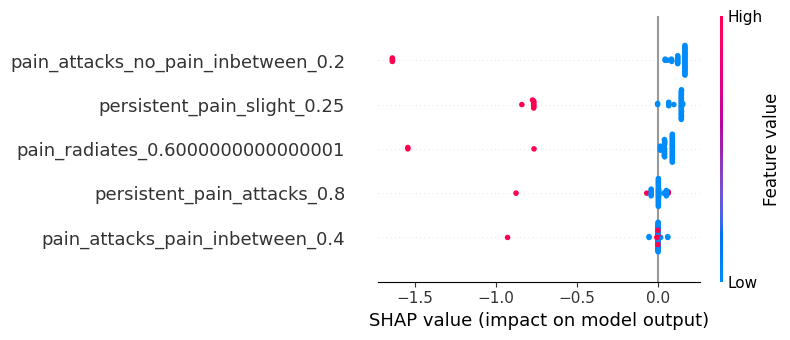

(            Classifier  Accuracy  Weighted F1 Score  Best Params
 n_neighbors        KNN  0.333333           0.274642            3,
 [Index(['persistent_pain_attacks_0.8', 'persistent_pain_slight_0.25',
         'pain_radiates_0.6000000000000001', 'pain_attacks_pain_inbetween_0.4',
         'pain_attacks_no_pain_inbetween_0.2'],
        dtype='object')])

In [60]:
knnModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)

In [61]:
def randomForestModel(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [None, 10, 20, 30, 40, 50]}
    rf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=inner_cv)
    rf_search.fit(X_train, y_train)
    rf_pred = rf_search.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1_macro = f1_score(y_test, rf_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(rf_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = rf_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Random Forest",
        'Accuracy': rf_accuracy,
        'F1 Score Macro': rf_f1_macro,
        'Best Params': [rf_search.best_params_]
    })

    explainer_rf = shap.TreeExplainer(clf_selected)
    shap_values_rf = explainer_rf.shap_values(X_test_selected)
    shap.summary_plot(shap_values_rf[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list




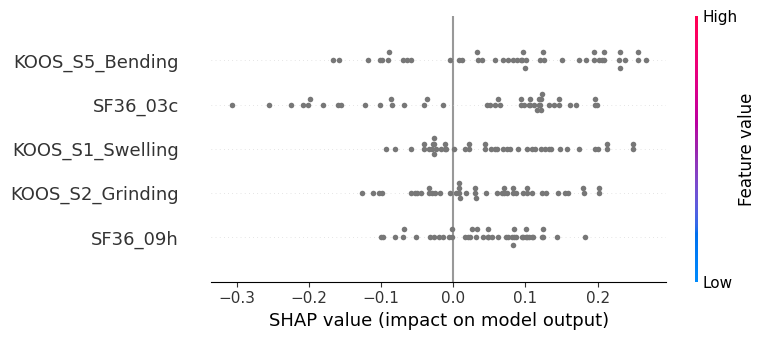

(      Classifier  Accuracy  F1 Score Macro  \
0  Random Forest  0.666667        0.361818   

                              Best Params  
0  {'max_depth': 10, 'n_estimators': 100}  , [Index(['KOOS_S2_Grinding', 'KOOS_S5_Bending', 'KOOS_S1_Swelling', 'SF36_03c',
       'SF36_09h'],
      dtype='object')])


In [62]:
results = randomForestModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [63]:
def annModel(X_train, X_test, y_train, y_test):
    ann_clf = MLPClassifier(max_iter=1000)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ann_param_grid = {'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)]}
    ann_search = HalvingGridSearchCV(ann_clf, ann_param_grid, cv=inner_cv)
    ann_search.fit(X_train, y_train)
    ann_pred = ann_search.predict(X_test)
    ann_accuracy = accuracy_score(y_test, ann_pred)
    ann_f1_macro = f1_score(y_test, ann_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(ann_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = ann_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Artificial Neural Network",
        'Accuracy': ann_accuracy,
        'F1 Score Macro': ann_f1_macro,
        'Best Params': [ann_search.best_params_]
    })

    explainer_ann = shap.KernelExplainer(clf_selected.predict_proba, X_train_selected)
    shap_values_ann = explainer_ann.shap_values(X_test_selected)
    shap.summary_plot(shap_values_ann, X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

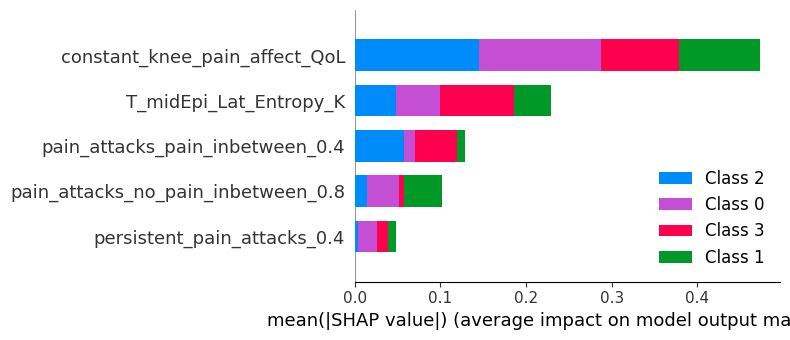

(                  Classifier  Accuracy  F1 Score Macro  \
0  Artificial Neural Network  0.333333        0.202486   

                      Best Params  
0  {'hidden_layer_sizes': (100,)}  , [Index(['persistent_pain_attacks_0.4', 'T_midEpi_Lat_Entropy_K',
       'constant_knee_pain_affect_QoL', 'pain_attacks_pain_inbetween_0.4',
       'pain_attacks_no_pain_inbetween_0.8'],
      dtype='object')])


In [64]:
results = annModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [65]:
def decisionTreeModel(X_train, X_test, y_train, y_test):
    dt_clf = DecisionTreeClassifier(max_depth=10)  # You can adjust max_depth as needed
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    dt_param_grid = {'max_depth': [None, 10, 20, 30, 40, 50]}
    dt_search = HalvingGridSearchCV(dt_clf, dt_param_grid, cv=inner_cv)
    dt_search.fit(X_train, y_train)
    dt_pred = dt_search.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_pred)
    dt_f1_macro = f1_score(y_test, dt_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(dt_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = dt_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Decision Tree",
        'Accuracy': dt_accuracy,
        'F1 Score Macro': dt_f1_macro,
        'Best Params': [dt_search.best_params_]
    })

    explainer_dt = shap.TreeExplainer(clf_selected)
    shap_values_dt = explainer_dt.shap_values(X_test_selected)
    shap.summary_plot(shap_values_dt[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df, selected_features_list

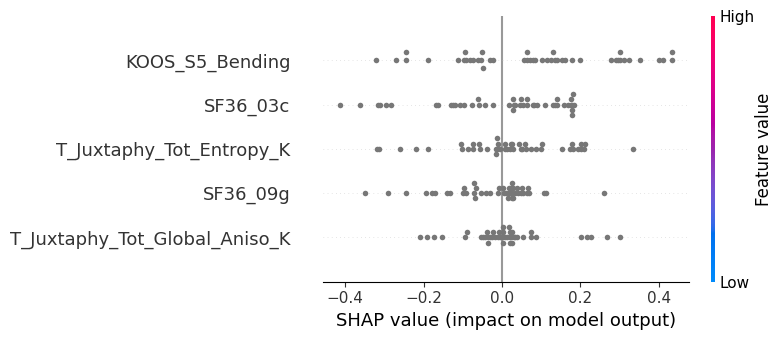

(      Classifier  Accuracy  F1 Score Macro        Best Params
0  Decision Tree  0.466667        0.347619  {'max_depth': 20}, [Index(['SF36_03c', 'T_Juxtaphy_Tot_Global_Aniso_K', 'KOOS_S5_Bending',
       'SF36_09g', 'T_Juxtaphy_Tot_Entropy_K'],
      dtype='object')])


In [66]:
results = decisionTreeModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)